In [2]:
!pip install ppi-python

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ppi_py
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
def build_fit_slr(x,y):
    """
    y_hat = model.predict(x)
    """
    model = LinearRegression()
    model.fit(x,y)
    return model

In [5]:
def build_fit_dt(x,y):
    """
    y_hat = model.predict(x)
    """
    model = DecisionTreeRegressor()
    model.fit(x,y)
    return model

In [6]:
def build_fit_rf(x,y):
    """
    y_hat = model.predict(x)
    """
    model = RandomForestRegressor()
    model.fit(x,y)
    return model

In [7]:
def sample_y_linear(x, m, beta, rho):
    """
    Given a sample of X, we generate Y as a linear function (SLR).
    """

    # compute sigma squared
    #sigma_squared = (beta**2)*gamma*(1.-rho)/rho
    sigma_squared = abs(m)*beta*(1.-(rho**2))/(rho**2)

    # sample noise (e_i)
    sampled_e = np.random.normal(loc=0,
                                 scale=sigma_squared*x,
                                 size=x.shape
                                 )

    # compute y as a linear function of x
    y = m*x + sampled_e

    return y


In [8]:
def sample_gamma_population(alpha,
                            beta,
                            sample_size,
                            m,
                            rho = None
                            ):
    """
    Sample <sample_size> instances, x_i ~ G(alpha, gamma)

    Then creates y_i ~ beta*x_i + e_i,
      where e_i ~ N(0, sigma^2_e*x_i), where
      sigma^2_e = (beta^2)gamma[(1-r^2)/)r^2]
      for rho(x_i, y_i) = r ==> desired correlation
    """

    assert np.any(rho != 0), "rho must be different from 0"

    # sample x
    x = np.random.gamma(alpha, beta, sample_size)

    # sample y
    y = sample_y_linear(x, m, beta, rho)

    return x, y



In [9]:
def f_wesley(xbar_star, ybar_star, x):
    """
    implementation of f, as defined by pdf.
    f(x_i) = \frac{\bar{Y}^{*}}{\bar{X}^{*}}(x_i)
    """
    assert np.any(xbar_star != 0), "xbar_star must be different from 0"

    return ybar_star*x/xbar_star



In [10]:
def ratio_estimator_mean(x_bar_unlabelled, x_bar_labelled, y_bar_labelled):
    """
    As defined in the pdf.
    """
    assert np.any(x_bar_labelled != 0), "x_bar_labelled must be different from 0"
    return x_bar_unlabelled*y_bar_labelled/x_bar_labelled

In [11]:
def ratio_estimator_variance(x_u, x_l, y_l, dof=1):
    """
    as defined from Sampling Theory and Practice (quite complete),
    p97 linearization

    Note, we use 1 degree of freedom for sample variance computation
    """
    # (xbar_tilde**2 / x_bar**2)(1- n/N)(var_y**2, + R^2var_x**2 - 2R*covar(x,y))

    # sample sizes
    x_u = x_u.reshape(1, -1)
    x_l = x_l.reshape(1, -1)
    y_y = y_l.reshape(1, -1)
    n = x_l.shape[1]
    N = x_u.shape[1]

    # means
    mu_x_u = x_u.mean(axis=1)
    x_l_mean = x_l.mean(axis=1)
    y_l_mean = y_l.mean(axis=1)
    r_hat = y_l_mean/x_l_mean

    # variances
    x_sample_var = np.var(x_l, axis=1, ddof=dof)
    y_sample_var = np.var(y_l, axis=1, ddof=dof)
    xy_covar = np.array([np.cov(x_l[i], y_l[i], ddof=dof)[0,1] for i in range(x_l.shape[0])])

    # implement term by term, treat the (1-n/N)*)(1/n) as one term
    term_one = (mu_x_u**2)/(x_l_mean**2)
    term_two = (1.0 - float(n/N))/n
    term_three = y_sample_var**2 + (r_hat**2)*(x_sample_var**2) - 2*r_hat*xy_covar

    variance = term_one*term_two*term_three
    return variance

In [12]:
def mean_absolute_bias(thetas, true_mean):
    """
    For B experimental repeats, computes the mean absolute error (mean bias error)
    across all B experiments.
    """
    errors = thetas - true_mean
    errors = abs(errors)
    errors = errors.reshape(1, -1)
    return np.mean(errors, axis=1)



In [13]:
#################
# constants
#################

# first population
ALPHA_1 = 1.0
GAMMA_1 = 2.0
# second population
ALPHA_2 = 1.4
GAMMA_2 = 1.6


# Y relationship
RHO = 0.4
BETA = 3.2

# data generation sizes
N_TRAIN = 5000
n = 300
N = 10000

# Expected value of X both distributions
EXPECTED_FIRST_DISTRIBUTION_MEAN_X = ALPHA_1*GAMMA_1
EXPECTED_SECOND_DISTRIBUTION_MEAN_X = ALPHA_2*GAMMA_2

# Expected value of Y both distributions (via Wesley formula)
EXPECTED_FIRST_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_1**2)*(GAMMA_1**2)/(RHO**2)
EXPECTED_SECOND_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_2**2)*(GAMMA_2**2)/(RHO**2)


print("TRUE MEAN OF 1st X distribution: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("TRUE MEAN OF 2nd X distribution: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_Y)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_Y)



# Expected value of Y
EXPECTED_TRUE_MEAN = EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA

TRUE MEAN OF 1st X distribution:  2.0
TRUE MEAN OF 2nd X distribution:  2.2399999999999998
EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION):  6.4
EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION):  7.167999999999999
EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION):  819.2
EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION):  1027.6044800000002


_________________________________
Let's do some playing
________________________________


In [14]:
# generate initial dataset
X_star, Y_star = sample_gamma_population(ALPHA_1,
                                        GAMMA_1,
                                        N_TRAIN,
                                        BETA,
                                        RHO
                                        )
X_star, Y_star = X_star.reshape(1, -1), Y_star.reshape(1, -1)
print("X_star (first distribution) mean: ", X_star.mean(), ", and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("Y_star (first distribution) mean: ", Y_star.mean(), " and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)

X_star (first distribution) mean:  2.0115461579351184 , and expected value:  2.0
Y_star (first distribution) mean:  9.066088620818174  and expected value:  6.4


In [15]:
# generate second dataset, labelled
X_gold, Y_gold = sample_gamma_population(ALPHA_2,
                                        GAMMA_2,
                                        n,
                                        BETA,
                                        RHO
                                        )
X_gold, Y_gold = X_gold.reshape(1, -1), Y_gold.reshape(1, -1)
print("X_labelled (second distribution) mean: ", X_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_labelled (second distribution) mean: ", Y_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_labelled (second distribution) mean:  2.144552161291678 , and expected value:  2.2399999999999998
Y_labelled (second distribution) mean:  5.556356876791233 , and expected value:  7.167999999999999


In [16]:
# generate second dataset, unlabelled
X_unlabelled, Y_unlabelled = sample_gamma_population(ALPHA_2,
                                                    GAMMA_2,
                                                    N,
                                                    BETA,
                                                    RHO
                                                    )
X_unlabelled, Y_unlabelled = X_unlabelled.reshape(1, -1), Y_unlabelled.reshape(1, -1)
print("X_Unlabelled (second distribution) mean: ", X_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_Unlabelled (second distribution) mean: ", Y_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_Unlabelled (second distribution) mean:  2.2713686249824416 , and expected value:  2.2399999999999998
Y_Unlabelled (second distribution) mean:  7.141768704877843 , and expected value:  7.167999999999999


In [17]:
# Using our pre-trained model, let's do inference on X_gold and X_tilde for PPI
Y_labelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_gold)
Y_unlabelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_unlabelled)

print("f_wesley(X_labelled) (second distribution) mean: ", Y_labelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)
print("f_wesley(X_Unlabelled) (second distribution) mean: ", Y_unlabelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)


f_wesley(X_labelled) (second distribution) mean:  9.665549989762958 , and expected value:  7.167999999999999
f_wesley(X_Unlabelled) (second distribution) mean:  10.237114949315986 , and expected value:  7.167999999999999


In [18]:
# PPI (not PPI++)
Y_gold = Y_gold.squeeze()
Y_labelled_tilde = Y_labelled_tilde.squeeze()
Y_unlabelled_tilde = Y_unlabelled_tilde.squeeze()
theta_ppi = ppi_py.ppi_mean_pointestimate(Y_gold,
                                          Y_labelled_tilde,
                                          Y_unlabelled_tilde,
                                          lhat=1)

print("Theta (PPI) point estimate: ", theta_ppi)

# CI
ci_ppi = ppi_py.ppi_mean_ci(Y_gold,
                            Y_labelled_tilde,
                            Y_unlabelled_tilde,
                            alpha=0.1,
                            alternative='two-sided',
                            lhat=1)

print("Theta_ppi: ", theta_ppi, " with CI: ", ci_ppi, " and width: ", str(ci_ppi[1] -ci_ppi[0]))

Theta (PPI) point estimate:  [6.12792184]
Theta_ppi:  [6.12792184]  with CI:  (array([-0.65900542]), array([12.91484909]))  and width:  [13.57385452]


In [19]:
# Ratio estimator
Y_gold = Y_gold.reshape(1, -1)
theta_re = ratio_estimator_mean(X_unlabelled.mean(), X_gold.mean(), Y_gold.mean())

#x_u, x_l, y_l,
re_variance = ratio_estimator_variance(X_unlabelled, X_gold, Y_gold)
print("Ratio estimation: ")
print("Point estimate: ", theta_re, " , variance: ", re_variance)
print("CI: [", theta_re-1.96*np.sqrt(re_variance), ", ", theta_re+1.96*np.sqrt(re_variance), "]")
print("CI width: ",  theta_re+1.96*np.sqrt(re_variance) - (theta_re-1.96*np.sqrt(re_variance)))


Ratio estimation: 
Point estimate:  5.8849278217358  , variance:  [95956.58592035]
CI: [ [-601.26152936] ,  [613.03138501] ]
CI width:  [1214.29291437]


In [20]:
# classic estimator
theta_classic = Y_gold.mean()
print(theta_classic)

variance_classes = Y_gold.var()

print("Classical: ")
print("Point estimate: ", theta_classic, " , variance: ", variance_classes)
print("CI: [", theta_classic-1.96*np.sqrt(variance_classes), ", ", theta_classic+1.96*np.sqrt(variance_classes), "]")
print("CI width: ",  theta_classic+1.96*np.sqrt(variance_classes) - (theta_classic-1.96*np.sqrt(variance_classes)))

5.556356876791233
Classical: 
Point estimate:  5.556356876791233  , variance:  5126.38229906841
CI: [ -134.7772108826768 ,  145.88992463625925 ]
CI width:  280.66713551893605


In [21]:
# errors in bias
classic_errors = mean_absolute_bias(theta_classic, EXPECTED_TRUE_MEAN)
theta_ppi_errors = mean_absolute_bias(theta_ppi, EXPECTED_TRUE_MEAN)
theta_re_errors = mean_absolute_bias(theta_re, EXPECTED_TRUE_MEAN)

print("Classic theta mean bias: ", classic_errors)
print("PPI theta mean bias: ", theta_ppi_errors)
print("RE theta mean bias: ", theta_re_errors)


Classic theta mean bias:  [1.61164312]
PPI theta mean bias:  [1.04007816]
RE theta mean bias:  [1.28307218]


QUestions:


*   non-iid vs iid
*   as the two distributions change progressively, how are iid vs non-iid differ (does performance degrade more or less?)
*   as f degrades (both in terms of 1st distribution and performance on the second 2)
*    Wesley's hypothesis: that the variance of ratio estimator should be close to the diferrence variance (sigma of f - Y) ... it is the variance component from the PPI
*    



RE estimator
- can't just pull the denominator out for variance.... since we have to estimate that, we have a ratio of 2 estimates, and so the variance term must be computed in some manner...

# TODO:
1. Explictly compute the variance components of ppi
2. Compute the mean estimate (and bias) of f on new data, then we can see how well it corrects.
3. Implement an ML function, f (simple non-linear regressor, or even a linear model.
4. How can we degrade f?
5. How can we implement non-IID (different D, what about dependent?)
  - do stratified sampling, and then split them (example, large X values vs small X values in different Unlab/Lab)
6. Pick large N
  - what size N for first population? use 2N?
7. Pick several values of n (exponential from 2 to N)
8. Pick different correlations (1.0,0.7,0.4, 0.1, -0.1, ..., -1.0)
9. Gamma distributions - Covariate shift
  - Fix GAMMA for all distributions (GAMMA = 1)
  - Start with ALPHA_1 = 5
  - we can measure distance (covariate shift) by modulating ALPHA_2 in [0.5, 1.0, 1.5, 2.0, ..., 4.5, 5.0, 5.5, ...., 10.0]
  - Fix BETA = 4.2, or every experiment we randomly sample it around something
  - this experiment tests robustness to distribution drift
  - for results, we can even show all the gamma curves on one plot, have all of them transparent, and have the matplotlib.pyplot alpha=1 for the "current" gamma curve we want to speak to, and on the side show relevant metrics
  - a table showing n vs classic vs ppi vs RE for bias, coverage and CI width
  - wesley also wants to see the variance terms

  10. Gamma distributions - Label drift
    - Now fix GAMMA for all distributions again
    - Start again with ALPHA_1 = 5, BETA = 4.2 for init population
    - Then, we move ALPHA_2 around in [3,4,6,7], so X density changes a bit, but we also modify BETA_2 in [some range of values smaller and larger]
    - Here, we expect the model to be more and more garbage, the past data will hurt
    - report same results

11. RHO
  - right now, this has no effect
  - the real RHO is related to beta....
  - larger (and more negative) BETA is
  - the more noise we add from e_i
  - we


  NOTES:
  - we need to do multiple experiments (highly, little, little negative, highly negative) correlations per bigger experiment (ex. covariate, label drift)
  -


[ 0.5   1.45  2.4   3.35  4.3   5.25  6.2   7.15  8.1   9.05 10.  ]


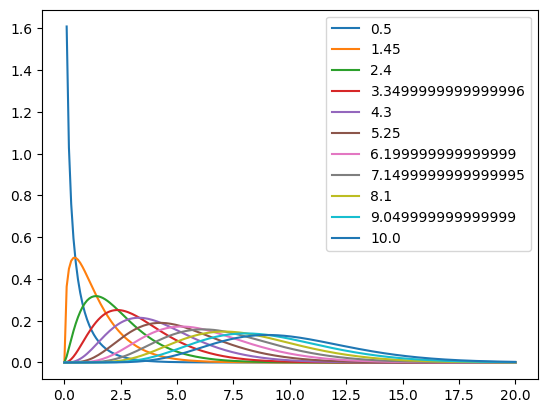

In [22]:
import matplotlib. pyplot as plt
import numpy as np
from scipy. stats import gamma

import scipy.stats as stats
from matplotlib import pyplot as plt

alphas = np.linspace(0.5, 10,11)
print(alphas)
x = np.linspace (0, 20, 200)
for alpha in alphas:
    y1 = stats.gamma.pdf(x, a=alpha, scale=1) #a is alpha, loc is beta???
    plt.plot(x, y1, label=str(alpha))
    plt.legend()



In [23]:
# Main script for covariate shift





In [61]:
# Testing and graphs

import pandas as pd

def plot_ci(predictions, lower, upper, true_value=None, categories=None):
    """
    Plots confidence intervals of a predictor. Predictions and widths should be the same type/dimensional array.


    predictions: array of predictions of length l
    lower: array of lower confidence interval estimates of predictions of length l
    upper: array of upper confidence interval estimates of predictions of length l
    true_value (optional): true value of prediction, if available
    categories (optional): list of names of methods
    """
    predictions = np.array(predictions).flatten()
    lower = np.array(lower).flatten()
    upper = np.array(upper).flatten()
    df = {}

    if categories:
        df['method'] = categories
    
    df['lower'] = lower
    df['upper'] = upper

    df = pd.DataFrame(df)

    for lower,upper,y in zip(df['lower'],df['upper'],range(len(df))):
        plt.plot((lower,upper),(y,y),'ro-',color='orange')

    if true_value:
        plt.axvline(x = true_value, ls='--', label = 'True value')
    
    if categories:
        plt.yticks(range(len(df)),list(df['category']))

    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')


/tmp/ipykernel_1472/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


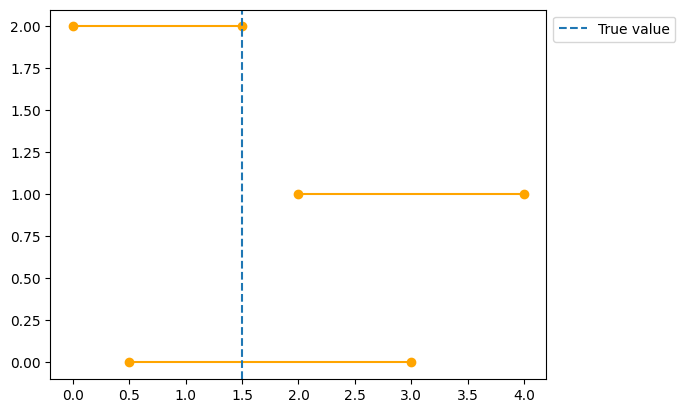

In [62]:
preds = np.array([[2, 3, 1]])
lower = [0.5, 2, 0]
upper = [3, 4, 1.5]

plot_ci(preds, lower, upper, true_value=1.5)

The following is a simple experiment, where we suppose we have two initial gamma distributions, $\mathbb{P}^u = 
\mathbb{P}^\ell$, with certain parameters. We will generate our training set $y = mx + 
\varepsilon$, here we will choose $\varepsilon \sim N(0, \sigma)$ for some small $\sigma$. We will train a model (probabily linear regression), then perform PPI, naive imputation, and classical (TBD what classical will be). We will also sample the true $y$ values, but the ML model will not be able to peek at it. 

[3.64870945]


/tmp/ipykernel_1472/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


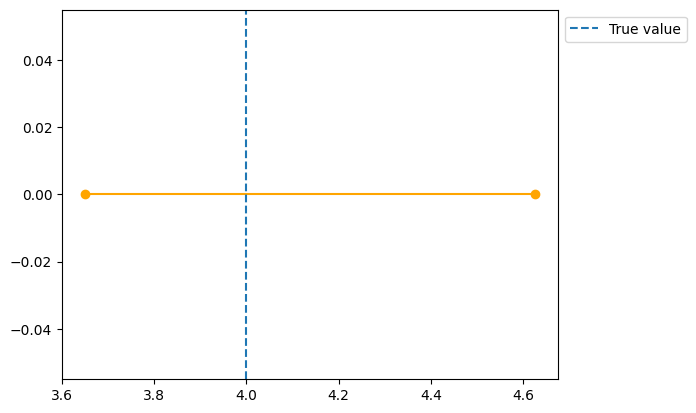

In [67]:
# PPI Testing, Experiment 0

preds = []
lowers = []
uppers = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

x_train, y_train = sample_gamma_population(alpha, beta, small_sample, m, rho)  

x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

x_train = np.array(x_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
x_ppi = np.array(x_ppi).reshape(-1, 1)
y_ppi = np.array(y_ppi).reshape(-1, 1)

model = build_fit_slr(x_train, y_train)

y_gold_fitted = model.predict(x_train)  # Gold standard fitted
y_fitted = model.predict(x_ppi)  # Unlabelled fitted

# Manual rectifier computation
rectifier = np.mean(y_gold_fitted - y_train)

theta = ppi_py.ppi_mean_pointestimate(y_train, y_gold_fitted, y_fitted)
theta_ci = ppi_py.ppi_mean_ci(y_train, y_gold_fitted, y_fitted)

print(theta_ci[0])

preds.append(theta)
lowers.append(theta_ci[0])
uppers.append(theta_ci[1])
true_mean = m * alpha * beta


plot_ci(preds, lowers, uppers, true_value=true_mean)

In [60]:
x = np.array([1]).reshape(-1, 1)
x = x.squeeze()
x

array(1)